# mcmc.ipynb
### A Markov-Chain Monte Carlo (MCMC) example using `kiauhoku` with `emcee`.
### For this example, we will estimate the Sun's age using gyrochronology (rotation-based age).

In [1]:
import numpy as np
import pandas as pd
import emcee

import kiauhoku as kh

### We must first define the log-probability function. Here I'm using an uninformative (flat) prior with a $\chi^2$ log-likelihood.

In [2]:
def lnprior(theta):
    return 0

def lnlike(theta, grid, data, sigma):
    mass, met, alpha, eep = theta   # unpack parameters
    star = grid.get_star_eep(*theta)
    if star.isnull().any():
        return -np.inf, None

    teff = 10**star['Log Teff(K)']
    star['Teff(K)'] = teff

    z_x_surf = np.log10(star['Z/X(surf)']/0.02289)
    star['[Z/X]'] = z_x_surf
    star['[alpha/Z]'] = alpha

    prot = star['Prot(days)']

    theta_ = np.array([teff, z_x_surf, alpha, prot])
    my_log_like = lnChiSq(theta_, data, sigma)
    return my_log_like, star

def lnChiSq(theta, data, sigma):
    return -0.5 * (((theta-data)/sigma)**2).sum()

### `kiauhoku` samples the model grid using independent variables of initial mass, initial metallicity, initial $\alpha$-element abundance, and EEP index, but those are rarely useful when comparing with data. 
### So we sample the grid and get useful parameters like temperature and luminosity, then we compute the log-probability using those values.

In [3]:
def lnprob(theta, grid, data, sigma):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf, None

    ll, star = lnlike(theta, grid, data, sigma)

    if not np.isfinite(ll):
        return -np.inf, None

    my_log_prob = lp + ll
    star["lnprob"] = my_log_prob

    return my_log_prob, star

### Now we define our data. Using for the Sun:
### - Teff = 5776 +/- 100 K
### - \[M/H\] = 0.0 +/- 0.1
### - \[$\alpha$/M\] = 0.0 +/- 0.1
### - Period = 24.5 +/- 2.5 days

In [4]:
sun_data = np.array([5776, 0, 0, 24.5])
sun_sigma = np.array([100, 0.1, 0.1, 2.5])
args = (sun_data, sun_sigma)

initial_guess = {
    'initial mass': 1,
    'initial [M/H]': 0,
    'initial [alpha/M]': 0.2, 
    'eep': 300
}

guess_width = {
    'initial mass': 0.2,
    'initial [M/H]': 0.1,
    'initial [alpha/M]': 0.05,
    'eep': 20
}

n_walkers = 12
n_burnin = 100
n_iter = 1000

grid = kh.load_interpolator('fastlaunch')

sampler, chains = grid.mcmc_star(
    lnprob, args,
    initial_guess, guess_width,
    n_walkers, n_burnin, n_iter,
)

100%|██████████| 1000/1000 [00:32<00:00, 31.17it/s]


### Now that we've run MCMC, we can use `corner.py` to see (qualitatively) how well the sampler converged.

In [5]:
from corner import corner

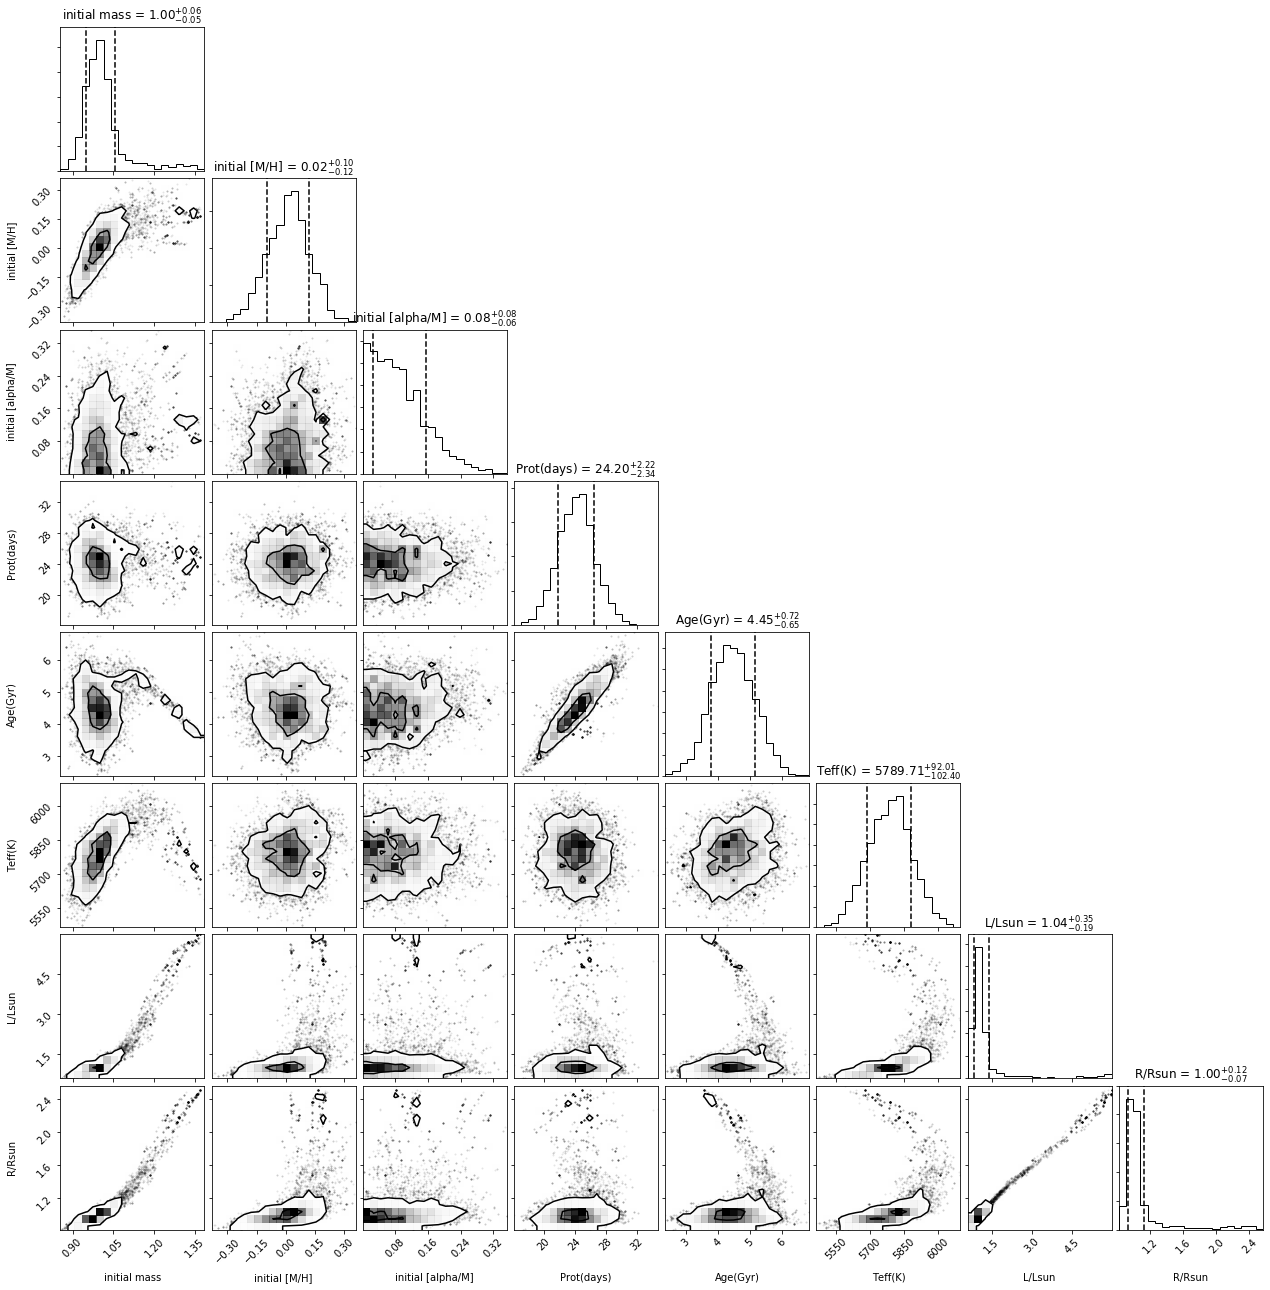

In [6]:
fig = corner(chains[['initial mass', 'initial [M/H]', 'initial [alpha/M]', 'Prot(days)', 
    'Age(Gyr)', 'Teff(K)', 'L/Lsun', 'R/Rsun']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)))

### It's in the right place, but looks like there are more evolved models that fit the same data. We can fix this by putting a prior on the EEP-index. If we know the Sun is a main-sequence star, we can limit the range of sampled EEPs to be on the main sequence. Try it out!